In [1]:
import random

"""Breaking down tanh to its constituents.


"""
import math
import numpy as np
import matplotlib.pyplot as plt

In [74]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self.label = label
        self._backward = lambda: None
        self.grad = 0
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data}, children={self._prev}, operator={self._op}, label={self.label})"

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (other, self), '+')

        def _backward():
            """Backward propagation function.

            Here we want to create a closure that can compute the self and other grads based on the out.grad.

            For further examples we have seen that during an addition the gradient is backpropagated without any transformations.
            """
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (other, self), '*')

        def backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = backward

        return out

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def exp(self):
        x = self.data
        # exp is having "e" as the base of the exponentiation
        out = Value(math.exp(x), (self,), 'exp')

        def backward():
            # d(e^x)/dx = e^x and since we assigned e^x to out.data
            self.grad += out.data * out.grad


        out._backward = backward
        return out

    def __pow__(self, other, modulo=None):
        assert isinstance(other, (int, float)), "Only supporting ints and floats for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def backward():
            # This is a reminder that this term  "* out.grad" is needed to make proper use of the chain rule
            self.grad = other * self.data ** (other - 1) * out.grad

        out._backward = backward
        return out

    def __truediv__(self, other):
        return self * other ** -1

    def __sub__(self, other):
        return self + (-other)

    def __neg__(self):
        return self * -1

    def tanh(self):
        """tanh is a hyperbolic function https://en.wikipedia.org/wiki/Hyperbolic_functions."""
        # print(f"Inside tanh")
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')

        def backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = backward
        return out

    def backward(self):
        topo: list[Value] = []
        visited: set[Value] = set()

        def build_topological_order(v: Value):
            if v is None:
                return

            if v in visited:
                return

            for child in v._prev:
                build_topological_order(child)

            topo.append(v)
            visited.add(v)

        build_topological_order(self)

        self.grad = 1
        for node in reversed(topo):
            node._backward()



In [35]:
from graphviz import Digraph


# DFS
def trace(root):
    nodes, edges = set(), set()

    def build(v, number_of_tabs=0):
        if v not in nodes:
            indentation = number_of_tabs * '\t'
            # print(f"{indentation}Processing node {v}")
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child, number_of_tabs + 1)

    build(root)
    # print(nodes,edges)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    # print(f'Root is {root}')
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # print(f'This is n {n}')
        dot.node(name=uid, label="{ %s | data  %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [36]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')
# b = Value(1.3245, label='b')

# x1*w1 + x2*w2 + b: This is the dot product based on the perceptron definition sigma(x(i)*w(i)) + bibas
x1w1 = x1 * w1
x1w1.label = 'x1*w1'
x2w2 = x2 * w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'  # dot product result
o = n.tanh()
o.label = 'o'
o.backward()

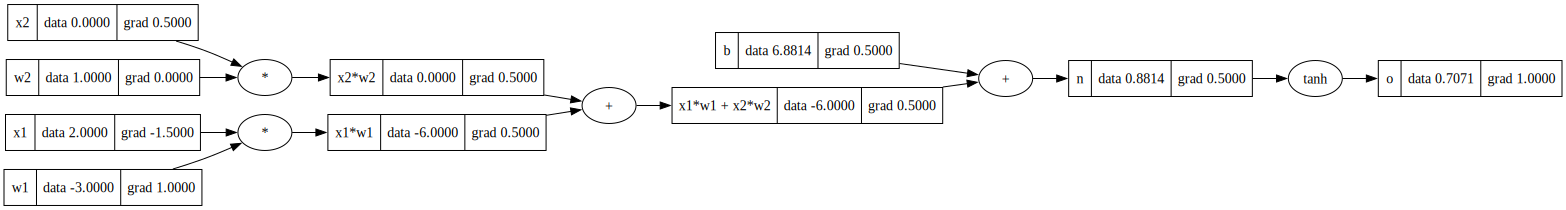

In [37]:
draw_dot(o)

In [38]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')
# b = Value(1.3245, label='b')

# x1*w1 + x2*w2 + b: This is the dot product based on the perceptron definition sigma(x(i)*w(i)) + bibas
x1w1 = x1 * w1
x1w1.label = 'x1*w1'
x2w2 = x2 * w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'  # dot product result
#---------------
# Instead of o = n.tanh() we can write. Again this comes from https://en.wikipedia.org/wiki/Hyperbolic_functions#Exponential_definitions and it is the hyperbolic tangent
e = (2 * n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()

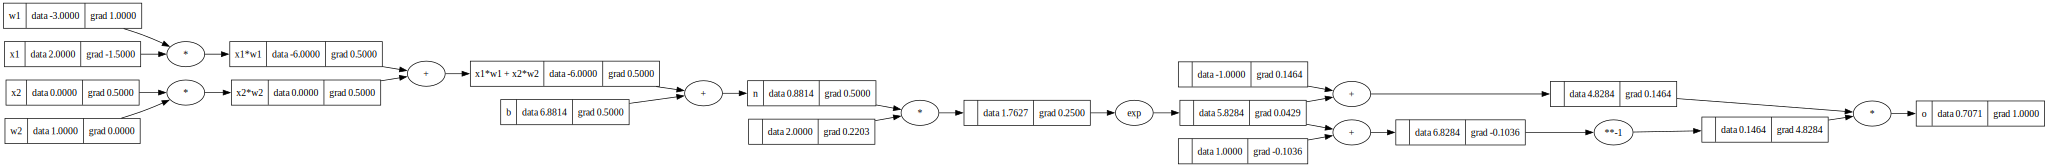

In [39]:
draw_dot(o)

In [40]:
import torch

In [41]:
x1 = torch.Tensor([2.0]).double();
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double();
b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [42]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [77]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w*x +b
        # print(4.5 + Value(4))
        # print(list(zip(self.w,x)))
        # print(type(initial_sum))
        act: Value = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
        # return 0.0


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs


class MLP:
    def __init__(self, nin, nouts: list):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


# Now let's create an MLP(Multi Layer perceptron) that has
# 1. 3 inputs
# 2. 2 3-dimensional hidden layers and
# 3. One output
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

n(x)

Value(data=0.9334660626467747)

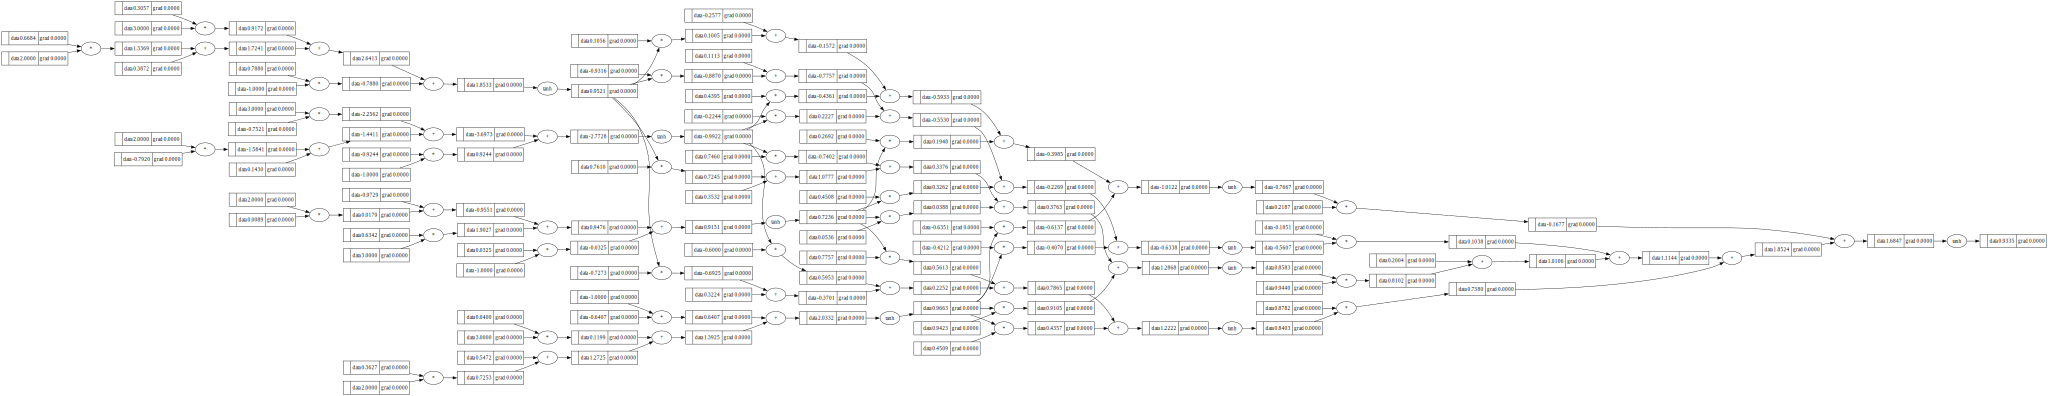

In [78]:
draw_dot(n(x))